<div style="border:solid gray 2px; padding: 20px">  
    
<b> Описание проекта: </b>
    
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах.  
То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.  

Необходимо:  
- Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.  
    
- Построить модель со значением метрики качества F1 не меньше 0.75. 

## Подготовка данных

### Импорт Библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import json

# Подготовка данных
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Модели
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.dummy import DummyClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Метрики
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Обработка текста
import re

# Загрузка файла
import requests
import urllib
from urllib.parse import urlencode


RANDOM = 12345

In [2]:
pth1 = '/Users/macbookair13i5/Desktop/datasets/Datasets/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
pth3 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
else:
    display('Something is wrong')

In [3]:
pd.set_option('display.max_colwidth', 500)

In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
# Удалим неинформатиыный столбец "Unnamed: 0"

df = df.drop(['Unnamed: 0'], axis = 1)

### Соотношение классов

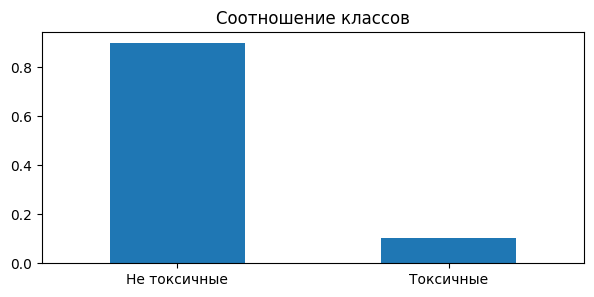

In [7]:
# Посмотрим на соотношение классов
fig,ax = plt.subplots(figsize = ((7,3)))
df['toxic'].value_counts(normalize = True).plot(
    kind = 'bar',
    title = 'Соотношение классов'
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0)
plt.show()

In [8]:
# Проверка явных дубликатов

print(f'Дубликатов до очистки текста: {df.duplicated().sum()}')

Дубликатов до очистки текста: 0


### Очистка текста

In [9]:
def clear_text(text):
    
    clear=re.sub(r'[^a-zA-Z]', ' ', text) # все кроме букв
    clear=re.sub(r"\s+[a-zA-Z]\s+", ' ', clear) # одиночные буквы
    clear=re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join(clear.split())

In [10]:
# Очистка текста

df['text'] = df['text'].apply(clear_text).str.lower()

In [11]:
df.head()

,text,toxic
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren vandalisms just closure on some gas after voted at new york dolls fac and please don remove the template from the talk page since m retired now,0
1,d aww he matches this background colour m seemingly stuck with thanks talk january utc,0
2,hey man m really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0
3,more can make any real suggestions on improvement wondered if the section statistics should be later on or subsection of types of accidents think the references may need tidying so that they are all in the exact same format ie date format etc can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be backlog on articles for review so guess there may be delay until reviewer turn...,0
4,you sir are my hero any chance you remember what page that on,0


In [12]:
# Дубликаты после очистки текста

print(f'Дубликатов после очистки текста: {df.duplicated().sum()}')

Дубликатов после очистки текста: 1332


In [13]:
# УДалим дубликаты

df = df.drop_duplicates()

In [14]:
disabled_pipes = [ "parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)

/Users/macbookair13i5/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [15]:
def lemme_text(text):
    
    doc=nlp(text)
    
    return ' '.join([token.lemma_ for token in doc])

In [16]:
%%time

try:
    df = pd.read_csv('/Users/macbookair13i5/Desktop/datasets/Datasets/toxic_lemm.csv').drop(['Unnamed: 0'], axis = 1)

# Выполнялось Wall time: 10min 46s. Готовый файл выше по ссылке на ЯндексДиске

except:
    df['text'] = df['text'].apply(lemme_text)

CPU times: user 549 ms, sys: 84.4 ms, total: 634 ms
Wall time: 644 ms


In [17]:
df = df.dropna()

In [18]:
df.head()

,text,toxic
0,explanation why the edit make under -PRON- username hardcore metallica fan be revert -PRON- weren vandalisms just closure on some gas after vote at new york doll fac and please don remove the template from the talk page since m retire now,0
1,d aww -PRON- match this background colour m seemingly stick with thank talk january utc,0
2,hey man m really not try to edit war -PRON- just that this guy be constantly remove relevant information and talk to -PRON- through edit instead of -PRON- talk page -PRON- seem to care more about the formatting than the actual info,0
3,more can make any real suggestion on improvement wonder if the section statistic should be later on or subsection of type of accident think the reference may need tidy so that -PRON- be all in the exact same format ie date format etc can do that later on if no one else do first if -PRON- have any preference for format style on reference or want to do -PRON- -PRON- please let -PRON- know there appear to be backlog on article for review so guess there may be delay until review turn up -PRON- l...,0
4,-PRON- sir be -PRON- hero any chance -PRON- remember what page that on,0


### Разделение на обучающую и тестовую выборки

In [19]:
# train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    df["text"], df["toxic"], test_size=0.1, random_state=RANDOM
)

In [20]:
# Размеры выборок

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(142162,)
(15796,)
(142162,)
(15796,)


### Векторизация Текста

In [21]:
# tfidf + разбиение на n-grams

vector = TfidfVectorizer(
    stop_words = 'english', # стоп слова
    
    max_features=15000,                      # количество признаков 15000
    min_df = 5,                                # минимальное количество встречаемости слов - 5
    max_df = 0.7,                               # ограничение встречаемости слов выше 70 %
    ngram_range = (1, 2),                      # н-граммы
    binary = True                              # бинарная классификация
)

In [22]:
# Обучение Векторайзера на train'e

vectorizer = vector.fit(features_train)

In [23]:
vectorizer

TfidfVectorizer(binary=True, max_df=0.7, max_features=15000, min_df=5,
                ngram_range=(1, 2), stop_words='english')

In [24]:
# Функция Векторизации

def vectorizing(features):
    vector=vectorizer.transform(features)
    return vector

In [25]:
# Векторизация выборок

features_train = vectorizing(features_train)
features_test = vectorizing(features_test)

## Обучение моделей

In [26]:
# Для результатов
best_est = []
best_params = []
best_score = []

In [27]:
# LightGBM

lgb = lgb.LGBMClassifier(n_jobs=-1, random_state=RANDOM)

In [28]:
# LogisticRegression и LinearSVC

logistic = LogisticRegression(n_jobs=-1, random_state=RANDOM)
LinearSVC = LinearSVC(random_state=RANDOM)

In [29]:
model_list = [logistic, LinearSVC, lgb]
model_name = ['LogisticRegression', 'LinearSVC', 'LGBMClassifier']

### Подбор гиперпараметров (RandomizedSearchCV)

In [30]:
# Гиперпараметры для LogisticRegression

log_params = {
    'C': [.1, 1, 2, 3, 5, 10, 12],
    'class_weight': ['balanced', None],
    'penalty': ['l2'],
    'solver': ['sag']
}

In [31]:
# Гиперпараметры для LinearSVC

svc_params = {
    'C': [.1, .5, 1, 2, 3, 8, 10, 13],
    'max_iter' : [100],
}

In [32]:
# Гиперпараметры для LGBMClassifier

lgb_params = {
    'boosting_type': ['gbdt', 'dart'], 
    'num_leaves': [31, 35, 40], 
    'n_estimators': range(10, 200, 10), 
    'class_weight': ['balanced', None]
}
             

In [33]:
params_list = list([log_params, svc_params, lgb_params])

<div class="alert alert-info">
    
<b>Комментарий:

Подбор лучших гиперпараметров занял достаточно много времени (Wall time: 1h 12min 9s)
Код ниже закоментирован, лучшие гиперпараметры сохранены отдельно

In [34]:
# Закоментировано, лучшие гиперпараметры сохранены отдельно
#%%time
#
## Подбор лучших Гиперпараметров
#
#for n, model in enumerate (model_list):
#    rs_model = RandomizedSearchCV(model, params_list[n], scoring = 'f1')
#    rs_model.fit(features_train, target_train)
#    print(rs_model.best_params_)
#    print(rs_model.best_estimator_)

In [35]:
log_best_params = {
    'solver': ['sag'],
    'penalty': ['l2'],
    'max_iter': [100],
    'class_weight':[ None],
    'C': [10]
}

In [36]:
svc_best_params = {
    'max_iter': [500],
    'C': [1]
}

In [37]:
lgb_best_params = {
    'num_leaves': [35],
    'n_estimators': [160],
    'class_weight': [None],
    'boosting_type': ['gbdt']
}

In [38]:
best_params.extend([log_best_params, svc_best_params, lgb_best_params])

## CrossValidation моделей с лучшими гиперпараметрами

### Dummy

In [39]:
# Проверим на константной модели

dummy = DummyClassifier()

In [40]:
start = time.time()
dummy.fit(features_train, target_train)
end_fit = time.time() - start
dummy_pred_train = dummy.predict(features_train)
dummy_f1_train = f1_score(dummy_pred_train, target_train)

print(f'f1-Dummy: {dummy_f1_train}')

f1-Dummy: 0.0


Качество Dummy Нулевое

In [41]:
%%time
# Обучение и кроссвалидация моделей GridSearchCV (Wall time: 5min 59s)

best_est = []
best_score = None
best_grid_train_score = []
time_training_list = []


for n, model in enumerate(model_list):
    grid_model = GridSearchCV(model, best_params[n], scoring = 'f1')
    
    # Время обучения
    start = time.time()
    grid_model.fit(features_train, target_train)
    end = time.time() - start
    time_training_list.append(end)
    
    # F1-мера
    best_grid_train_score.append(grid_model.best_score_)
    
    #Лучшая модель
    best_est.append(grid_model.best_estimator_)

CPU times: user 23min 31s, sys: 22.6 s, total: 23min 53s
Wall time: 8min 7s


In [42]:
best_score = 0
best_model = 0
best_model_name = None

for n, model in enumerate (best_est):
    print(f' {model_name[n]}, f1_score: {best_grid_train_score[n]}')
    if best_grid_train_score[n] > best_score:
        best_score = best_grid_train_score[n]
        best_model = model
        best_model_name = model_name[n]
print()        
print(f' Лучшая модель - {best_model_name}, f1: {best_score}')

 LogisticRegression, f1_score: 0.7709728601825399
 LinearSVC, f1_score: 0.7730282925178088
 LGBMClassifier, f1_score: 0.7610800270822972

 Лучшая модель - LinearSVC, f1: 0.7730282925178088


In [43]:
# Отобразим результаты в табличке

f1_train_models = pd.DataFrame(columns = model_name)

In [44]:
f1_train_models.loc['f1-мера', :] = best_grid_train_score
f1_train_models.loc['ВремяОбучения(сек.)', :] = time_training_list

In [45]:
print('Модели на обучающей выборке')
display(f1_train_models)

Модели на обучающей выборке


,LogisticRegression,LinearSVC,LGBMClassifier
f1-мера,0.770973,0.773028,0.76108
ВремяОбучения(сек.),19.512701,5.522361,462.182496


### На тестовой выборке

In [46]:
# Результаты прогноза и метрик на тестовой выборке

start = time.time()
test_pred = best_model.predict(features_test)
end = time.time() - start

best_test_score = f1_score(test_pred, target_test)
print(f'f1-мера лучшей модели ({best_model_name}) на тестовой выборке: {best_test_score}')

f1-мера лучшей модели (LinearSVC) на тестовой выборке: 0.7754373438057837


## Отчет

In [47]:
best_model_report = pd.DataFrame(columns = ['f1-score', 'time_fit', 'time_predict'])

In [48]:
best_model_report.loc[best_model_name, :] = [best_score, time_training_list[1], end]
best_model_report

,f1-score,time_fit,time_predict
LinearSVC,0.773028,5.522361,0.016652


### Матрица Ошибок

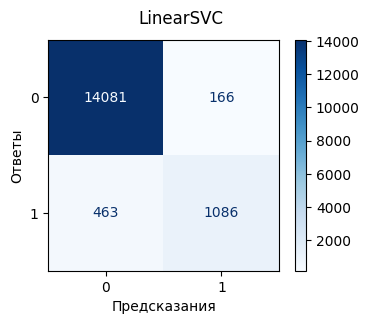

In [49]:
# Confusion_matrix

fig, ax = plt.subplots(figsize = (4,3))
cm = confusion_matrix(target_test, test_pred, labels = (0,1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(0,1))
disp.plot(cmap=plt.cm.Blues, ax = ax)
plt.suptitle(best_model_name)
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show()

## Общий вывод

<div style="border:solid gray 2px; padding: 20px">  
    
<b> В данном проекте: </b>
    
Использовали NLP для определения токсичности комментариев.  
    
По заданию нужно было обучить модель классифицировать комментарии на позитивные и негативные. Целевой признак - разметка данных о токсичности.  
    
**1. Была проведена обработка данных:**  
- Лемматизация и обработка регулярными выражениями.  
- Векторизация текста.  
    
**2. Использовали Модели для Классификации:** (Все модели показали приемлемое по условию проекта качество f1 >0.75)  
- LogisticRegression  
- **LinearSVC** показала Лучшее качество прогноза (f1 = 0.775)	
- LGBMClassifier

